In [1]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import splitfolders

from IPython.display import display
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation, Add, BatchNormalization, \
    Conv2D, Dense, Dropout, GlobalAveragePooling2D, Input, MaxPooling2D, Flatten, \
    ZeroPadding2D
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Explore the COVID-19 radiography database

In [2]:
# print the subdirectories of the database
database_path = 'covid-19_radiography_dataset'
dir_list = os.listdir(database_path)
print(dir_list)

['COVID', 'Lung Opacity', 'Normal', 'Viral Pneumonia']


In [3]:
# print the number of images per subdirectory
num_of_images = []
dir_iter = iter(dir_list)
for root, dirs, files in os.walk(database_path):
    if root == database_path: continue
    print('{}: {}'.format(next(dir_iter), len(files)))
    num_of_images.append(len(files))

COVID: 3616
Lung Opacity: 6012
Normal: 10192
Viral Pneumonia: 1345


Path: covid-19_radiography_dataset\COVID\COVID-2542.png
Size: (299, 299)
Mode: L
Format: PNG


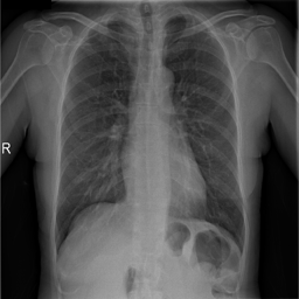

In [4]:
# print a random image's path, size, mode, and format
seed = 123
random.seed(seed)
rand_img = Image.open(random.choice(glob.glob(database_path + '/**/*')))

print('Path:', rand_img.filename)
print('Size:', rand_img.size)  # (299, 299)
print('Mode:', rand_img.mode)  # L: 8-bit grayscale
print('Format:', rand_img.format)  # PNG

display(rand_img)

### Visualize the COVID-19 radiography database

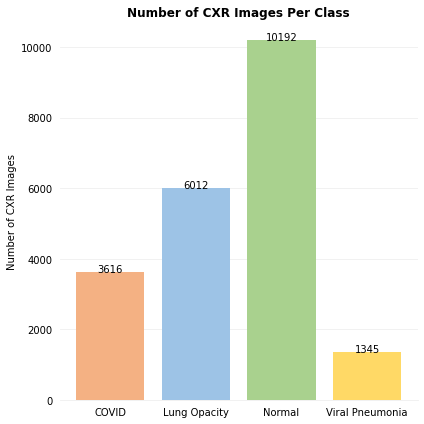

In [5]:
# visualize the number of images per subdirectory
x = np.arange(len(dir_list))
colors = ['#f4b183', '#9dc3e6', '#a9d18e', '#ffd966']

fig, ax = plt.subplots(facecolor='white', figsize=(6, 6))
ax.bar(x, num_of_images, color=colors)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#EEEEEE')

ax.yaxis.grid(True, color='#EEEEEE')
ax.set_axisbelow(True)

plt.xticks(x, dir_list)
ax.tick_params(bottom=False, left=False)

plt.title('Number of CXR Images Per Class', fontweight='bold')
plt.ylabel('Number of CXR Images')

for i in range(len(x)):
    plt.text(i, num_of_images[i], num_of_images[i], ha='center')

plt.tight_layout()
plt.savefig('figures/bar_chart.png', dpi=200)
plt.show()

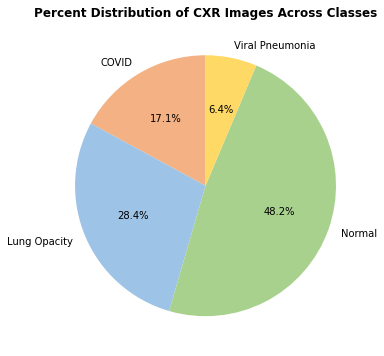

In [6]:
# visualize the % distribution of images across subdirectories
plt.figure(facecolor='white', figsize=(6,6))
plt.pie(num_of_images, labels=dir_list, colors=colors, autopct='%.1f%%', startangle=90)
plt.title('Percent Distribution of CXR Images Across Classes', fontweight='bold')
plt.savefig('figures/pie_chart.png', dpi=200)
plt.show()

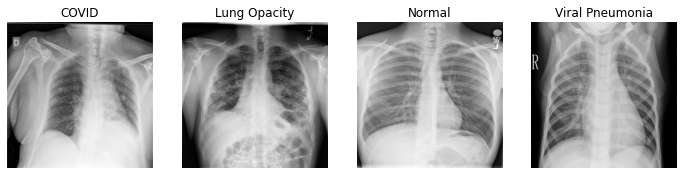

In [7]:
# display random CXR images, one from each class
dir_iter = iter(dir_list)
plt.figure(facecolor='white', figsize=(12,3))
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    dir_name = next(dir_iter)
    plt.imshow(
        Image.open(random.choice(glob.glob(database_path+'/'+dir_name+'/*'))),
        cmap='gray')
    plt.title(dir_name)
    plt.axis("off")
plt.savefig('figures/dataset_images.png', dpi=200)
plt.show()

### Generate the COVID-19 radiography dataset

In [8]:
# split the database folder into test, train, and val folders
output_path = 'dataset_subsets'
if not os.path.exists(output_path):
    splitfolders.ratio(database_path, output_path, seed, (.7, .1, .2))

In [9]:
# set test, train, and val folder paths
train_path = os.path.join(output_path, 'train')
val_path = os.path.join(output_path, 'val')
test_path = os.path.join(output_path, 'test')

In [10]:
# initialize flow_from_directory args
img_dims = 224
target_size = (img_dims, img_dims)
color_mode = 'rgb'
class_mode = 'categorical'
batch_size = 32

In [11]:
# take the path to the train folder and generate batches of augmented data
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=[0.9, 1.1],
    zoom_range=[0.9, 1.1],
    horizontal_flip=True)
train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    color_mode=color_mode,
    class_mode=class_mode,
    batch_size=batch_size,
    seed=seed)

Found 14814 images belonging to 4 classes.


In [12]:
# take the path to the val folder and generate batches of augmented data
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)
val_gen = val_datagen.flow_from_directory(
    val_path,
    target_size=target_size,
    color_mode=color_mode,
    class_mode=class_mode,
    batch_size=batch_size,
    seed=seed)

Found 2115 images belonging to 4 classes.


In [13]:
# take the path to the train folder and generate batches of augmented data
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    color_mode=color_mode,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=False,
    seed=seed)

Found 4236 images belonging to 4 classes.


### Analyze the COVID-19 radiography dataset

In [14]:
# print the paths to the directories to read images from
print(train_gen.directory)
print(val_gen.directory)
print(test_gen.directory)

dataset_subsets\train
dataset_subsets\val
dataset_subsets\test


In [15]:
# print the dictionary that maps class names to class indices
print(train_gen.class_indices)

{'COVID': 0, 'Lung Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [16]:
# check target_size, color_mode, class_mode, and batch_size
print(train_gen.target_size)
print(train_gen.color_mode)
print(train_gen.class_mode)
print(train_gen.batch_size)

(224, 224)
rgb
categorical
32


In [17]:
# print the shapes of the first training batch tuple
images, labels = next(iter(train_gen))
print('images shape:', images.shape)  # (batch_size, *target_size, channels)
print('labels shape:', labels.shape)  # (batch_size, num_classes)

images shape: (32, 224, 224, 3)
labels shape: (32, 4)


### Build a modified ResNet-50 model

In [18]:
def block(x, filters, strides=1, conv_shortcut=False):
    """
    A residual block.

    :param x: input tensor
    :param filters: integer, filter of the first and second layer
    :param strides: integer, stride of the first layer
    :param conv_shortcut: boolean, if it uses convolutional shortcut
    :return: output tensor for the residual block
    """
    # dotted line shortcut: a change in the dimension
    if conv_shortcut:
        shortcut = Conv2D(4 * filters, 1, strides)(x)
        shortcut = BatchNormalization()(shortcut)
    # solid line shortcut: no change in the dimension
    else:
        shortcut = x

    # first layer: reduces dimensions
    x = Conv2D(filters, 1, strides=strides)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer: bottleneck
    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # third layer: restores dimensions
    x = Conv2D(4 * filters, 1)(x)
    x = BatchNormalization()(x)

    # add skip connection
    x = Add()([shortcut, x])
    x = Activation('relu')(x)

    return x

In [19]:
def resnet50():
    """
    A ResNet-50 architecture.

    :return: A ResNet-50 convolutional base without a classifier layer
    """
    x_input = Input(shape=(img_dims, img_dims, 3))
    x = ZeroPadding2D(padding=(3, 3))(x_input)

    # build conv1 layer
    x = Conv2D(64, 7, strides=2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = MaxPooling2D(3, strides=2)(x)

    # build conv2_x layer
    x = block(x, 64, conv_shortcut=True)
    x = block(x, 64)
    x = block(x, 64)

    # build conv3_x layer
    x = block(x, 128, strides=2, conv_shortcut=True)
    x = block(x, 128)
    x = block(x, 128)
    x = block(x, 128)

    # build conv4_x layer
    x = block(x, 256, strides=2, conv_shortcut=True)
    x = block(x, 256)
    x = block(x, 256)
    x = block(x, 256)
    x = block(x, 256)
    x = block(x, 256)

    # build conv5_x layer
    x = block(x, 512, strides=2, conv_shortcut=True)
    x = block(x, 512)
    x = block(x, 512)

    return Model(inputs=x_input, outputs=x)

In [20]:
# instantiate the base model
base_model = resnet50()

In [21]:
# transfer the weights from the pretrained model into the base model
pretrained_model = ResNet50(include_top=False,
                            input_shape=(img_dims, img_dims, 3))
base_model.set_weights(pretrained_model.get_weights())

In [22]:
# build the entire ResNet-50 model
x = base_model.output
x = Conv2D(1024, 1)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)
model = Model(base_model.input, outputs)

In [23]:
# freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [24]:
# print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

### Train the custom ResNet50 model

In [25]:
# define hyper-parameters
EPOCHS = 25
ETA = 0.0001

In [26]:
# select metrics
metrics_list = ['categorical_accuracy', Precision(), Recall()]

In [27]:
# compile the model
model.compile(optimizer=Adam(ETA),
              loss='categorical_crossentropy',
              metrics=metrics_list)

In [28]:
# create a learning rate scheduler callback
def scheduler(epoch):
    if epoch > 20:
        return ETA * 0.1
    else:
        return ETA
callback = LearningRateScheduler(scheduler)

In [29]:
# estimate class weights for the unbalanced dataset
cls_wt = compute_class_weight(class_weight='balanced',
                              classes=np.unique(train_gen.labels),
                              y=train_gen.labels)
class_weight = {0: cls_wt[0], 1: cls_wt[1], 2: cls_wt[2], 3: cls_wt[3]}
print(class_weight)

{0: 1.4632556301856974, 1: 0.8801093155893536, 2: 0.5191337258200168, 3: 3.9357066950053134}


In [30]:
# train the model
history = model.fit(train_gen, epochs=EPOCHS, callbacks=callback,
                    validation_data=val_gen, class_weight=class_weight)

Epoch 1/25
 10/463 [..............................] - ETA: 21:37 - loss: 1.3465 - categorical_accuracy: 0.3812 - precision: 0.4563 - recall: 0.2937

KeyboardInterrupt: 

### Visualize the training results

In [ ]:
def visualize_history(metric, val_metric, y_label, title):
    """
    Plots a training history metric.

    :param metric: the metric key
    :param val_metric: the validation metric key
    :param y_label: the y-label
    :param title: the title
    :return: None
    """
    plt.figure(facecolor='white', figsize=(8, 6))
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.ylabel(y_label)
    plt.xlabel('epoch')
    plt.title(title)
    plt.legend(['training', 'validation'])
    plt.savefig('figures/' + title + '.png', dpi=200)
    plt.show()

In [ ]:
# visualize loss
visualize_history(metric='loss', val_metric='val_loss',
                  y_label='categorical crossentropy loss', title='Loss')

In [ ]:
# visualize accuracy
visualize_history(metric='categorical_accuracy',
                  val_metric='val_categorical_accuracy',
                  y_label='categorical accuracy', title='Accuracy')

In [ ]:
# visualize precision
visualize_history(metric='precision', val_metric='val_precision',
                  y_label='precision', title='Precision')

In [ ]:
# visualize recall
visualize_history(metric='recall', val_metric='val_recall',
                  y_label='recall', title='Recall')

### Evaluate the custom ResNet50 model

In [ ]:
# print metrics values for the model in test mode
result = model.evaluate(test_gen)
dict(zip(model.metrics_names, result))

In [ ]:
# generate output predictions for the test input samples
predictions = model.predict(test_gen)

In [ ]:
# initialize true and predicted label values
y_true = test_gen.labels
y_pred = np.argmax(predictions, axis=1)

In [ ]:
# build a text report showing the main classification metrics
report = classification_report(y_true, y_pred)
print(report)

In [ ]:
# plot a confusion matrix given true and predicted labels
fig, ax = plt.subplots(facecolor='white', figsize=(12, 8), dpi=100)
fig = ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                              display_labels=test_gen.class_indices,
                                              include_values=True,
                                              normalize='pred',
                                              values_format='.2f',
                                              cmap='viridis',
                                              ax=ax)
plt.title('Confusion Matrix', fontsize=15, fontweight='bold', pad=35)
plt.tick_params(left=False, bottom=False)
plt.savefig('figures/confusion_matrix.png', dpi=200)
plt.show()